In [1]:
!pip install pulp
!pip install ortoolpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 23.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 KB 820.6 kB/s eta 0:00:00
  Attempting uninstall: more-itertools
    Found existing installation: more-itertools 9.1.0
    Uninstalling more-itertools-9.1.0:
      Successfully uninstalled more-itertools-9.1.0


In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [3]:
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

In [4]:
print(pr)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [5]:
m1 = model_min()
v1 = {(i, j) : LpVariable('v%d_%d' % (i, j), lowBound=0) for i, j in pr}
print(v1)

{(0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3}


In [6]:
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
  m1 += lpSum(v1[i, j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
  m1 += lpSum(v1[i, j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

1

In [7]:
print(m1)

NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0
SUBJECT TO
_C1: v0_0 + v0_1 + v0_2 + v0_3 <= 35

_C2: v1_0 + v1_1 + v1_2 + v1_3 <= 41

_C3: v2_0 + v2_1 + v2_2 + v2_3 <= 42

_C4: v0_0 + v1_0 + v2_0 >= 28

_C5: v0_1 + v1_1 + v2_1 >= 29

_C6: v0_2 + v1_2 + v2_2 >= 31

_C7: v0_3 + v1_3 + v2_3 >= 25

VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous



In [8]:
df_tr_sol = df_tc.copy()
total_cost = 0
for k, x in v1.items():
  i, j = k[0], k[1]
  df_tr_sol.iloc[i][j] = value(x)
  total_cost += df_tc.iloc[i][j] * value(x)

print(df_tr_sol)
print("총 운송 비용: " + str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용: 1296.0


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

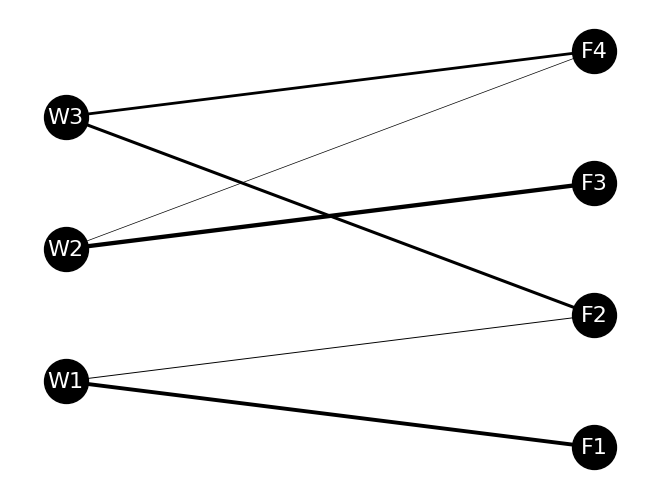

In [11]:
G = nx.Graph()

for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])

num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
  for j in range(len(df_pos.columns)):
    if not (i==j):
      G.add_edge(df_pos.columns[i], df_pos.columns[j])
      if num_pre < len(G.edges):
        num_pre = len(G.edges)
        weight = 0
        if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
        elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
          if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
            weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size
        edge_weights.append(weight)

pos = {}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node] = (df_pos[node][0], df_pos[node][1])

nx.draw(G, pos, with_labels = True, font_size = 16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

plt.show()

In [12]:
import pandas as pd
import numpy as np

df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [13]:
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [14]:
df_supply

,W1,W2,W3
0,35,41,42


In [16]:
df_tr

,F1,F2,F3,F4
공장,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


In [15]:
df_demand.columns

Index(['F1', 'F2', 'F3', 'F4'], dtype='object')

In [17]:
def condition_demand(df_tr, df_demand):
  flag = np.zeros(len(df_demand.columns))
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(temp_sum)
    if (temp_sum >= df_demand.iloc[0][i]):
      flag[i] = 1
  return flag

In [21]:
def condition_supply(df_tr, df_supply):
  flag = np.zeros(len(df_supply.columns))
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(temp_sum)
    if temp_sum <= df_supply.iloc[0][i]:
      flag[i] = 1
  return flag

In [19]:
print("수요 조건 계산 결과: " + str(condition_demand(df_tr_sol, df_demand)))

28
29
31
25
수요 조건 계산 결과: [1. 1. 1. 1.]


In [23]:
print("공급 조건 계산 결과: " + str(condition_supply(df_tr_sol, df_supply)))

35
36
42
공급 조건 계산 결과: [1. 1. 1.]


In [24]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv', index_col="제품")
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


In [29]:
def product_plan(df_profit, df_plan):
  profit = 0
  for i in range(len(df_profit.index)):
    for j in range(len(df_plan.columns)):
      profit += df_profit.iloc[i][j] * df_plan.iloc[i][j]
      print(df_profit.iloc[i][j], df_plan.iloc[i][j])
  return profit
  
print("총 이익: " + str(product_plan(df_profit, df_plan)))

5.0 16
4.0 0
총 이익: 80.0


In [32]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

df = df_material.copy()
inv = df_stock

In [35]:
m = model_max()
v1 = {(i): LpVariable('v%d'%(i), lowBound = 0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i] * v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
  m += lpSum(df_material.iloc[j, i] * v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:, i]
m.solve()

1

In [34]:
df_plan_sol = df_plan.copy()
for k, x in v1.items():
  df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익 : " + str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익 : 95.0


In [41]:
def condition_stock(df_plan, df_material, df_stock):
  flag = np.zeros(len(df_material.columns))
  for i in range(len(df_material.columns)):
    temp_sum = 0
    for j in range(len(df_material.index)):
      print(df_material.iloc[j][i], float(df_plan.iloc[j]))
      temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j])
    if (temp_sum <= float(df_stock.iloc[0][i])):
      flag[i] = 1
    print(df_material.columns[i] + " 사용량:" + str(temp_sum) + ", 재고: " + str(float(df_stock.iloc[0][i])))
  return flag

In [42]:
print("제약 조건 계산 결과: " + str(condition_stock(df_plan_sol, df_material, df_stock)))

1 15.0
2 5.0
원료1 사용량:25.0, 재고: 40.0
4 15.0
4 5.0
원료2 사용량:80.0, 재고: 80.0
3 15.0
1 5.0
원료3 사용량:50.0, 재고: 50.0
제약 조건 계산 결과: [1. 1. 1.]


In [54]:
import numpy as np
import pandas as pd

제품 = list('AB')
수요지 = list('PQ')
공장 = list('XY')
레인 = (2, 2)

tbdi = pd.DataFrame(((j, k) for j in 수요지 for k in 공장), columns=['대리점', '공장'])
tbdi['운송비'] = [1, 2, 3, 1]
print(tbdi)

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1


In [55]:
tbde = pd.DataFrame(((j, i) for j in 수요지 for i in 제품), columns=['대리점', '제품'])
tbde['수요'] = [10, 10, 20, 20]
print(tbde)

  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20


In [56]:
tbfa = pd.DataFrame(((k, l, i, 0, np.inf) for k, nl in zip(공장, 레인) for l in range(nl) for i in 제품), columns=['공장', '레인', '제품', '하한', '상한'])
tbfa['생산비'] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
tbfa.dropna(inplace=True)
tbfa.loc[4, '상한'] = 10
print(tbfa)

  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0


In [62]:
from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa, dep = '대리점', dem = '수요', fac = '공장', prd = '제품', tcs = '운송비', pcs = '생산비',
                               lwb = '하한', upb = '상한')
print(tbfa)

  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000100  20.0
3  X   1  B   0   inf  1.0  v000101  10.0
4  Y   0  A   0  10.0  3.0  v000102  10.0
6  Y   1  A   0   inf  5.0  v000103   0.0
7  Y   1  B   0   inf  3.0  v000104  20.0


/usr/local/lib/python3.9/dist-packages/ortoolpy/etc.py:1213: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  tbsm = pd.concat([tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1)


In [61]:
print(tbdi2)

  공장 대리점  운송비 제품     VarX  ValX
0  X   P    1  A  v000079  10.0
1  X   P    1  B  v000080  10.0
2  X   Q    3  A  v000081  10.0
3  X   Q    3  B  v000082   0.0
4  Y   P    2  A  v000083   0.0
5  Y   P    2  B  v000084   0.0
6  Y   Q    1  A  v000085  10.0
7  Y   Q    1  B  v000086  20.0


In [60]:
tbdi2 = tbdi2[["공장", "대리점", "운송비", "제품", "VarX", "ValX"]]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000079,10.0
1,X,P,1,B,v000080,10.0
2,X,Q,3,A,v000081,10.0
3,X,Q,3,B,v000082,0.0
4,Y,P,2,A,v000083,0.0
5,Y,P,2,B,v000084,0.0
6,Y,Q,1,A,v000085,10.0
7,Y,Q,1,B,v000086,20.0


In [63]:
trans_cost = 0
for i in range(len(tbdi2.index)):
  trans_cost += tbdi2["운송비"].iloc[i]*tbdi2["ValX"].iloc[i]

print("총 운송비: " + str(trans_cost))

총 운송비: 80.0


In [64]:
print(tbfa)

  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000100  20.0
3  X   1  B   0   inf  1.0  v000101  10.0
4  Y   0  A   0  10.0  3.0  v000102  10.0
6  Y   1  A   0   inf  5.0  v000103   0.0
7  Y   1  B   0   inf  3.0  v000104  20.0


In [65]:
product_cost = 0
for i in range(len(tbfa.index)):
  product_cost += tbfa["생산비"].iloc[i] * tbfa["ValY"].iloc[i]
  
print("총 생산비 : " + str(product_cost))

총 생산비 : 120.0
